In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from random import randrange
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
import sys
import time
from time import time
import pyarrow

## K-Means Preparinator
A notebook to compute silhouette scores and identify the best k. Part of the DUNE project (https://github.com/opendr-io/dune) for hunting threats that are resistant to conventional detection. The examples below are for analysis of CloudTrail logs; refactor as needed.


In [3]:
# input file - or you can ingest directly from S3 using the boto3 module'
# if you do that at great scale, you might run the notebook in the same region
# as the bucket to avoid egress charges
#csv_file_path = 'cloudtrail.csv'

In [6]:
# Read the file and extract relevant fields
#raw = pd.read_csv(csv_file_path, encoding='utf-8', low_memory=False)  # Adjust the encoding if needed
raw = pd.read_parquet("cloudtrail-large.parquet")
print('raw data shape and column names:')
print(raw.shape)
sdf = raw.copy()

raw data shape and column names:
(556575, 50)


In [8]:
# check for arrays
array_cols = []
for c in raw.columns:
    if raw[c].map(lambda v: isinstance(v, (list, tuple, np.ndarray))).any():
        array_cols.append(c)

print(array_cols)

['resources']


In [9]:
# keep only columns with hashable scalars
scalar_cols = [
    c for c in raw.columns
    if raw[c].map(lambda v: not isinstance(v, (list, tuple, np.ndarray))).all()
]
cardinality = raw[scalar_cols].nunique(dropna=True).sort_values(ascending=False)
for col, val in cardinality.items():
    print(f"{col}: {val}")


eventID: 555736
requestID: 547443
sharedEventID: 507563
eventTime: 398130
source_file: 248733
additionalEventData.x-amz-id-2: 14340
userIdentity.accessKeyId: 620
eventName: 325
errorMessage: 295
userIdentity.sessionContext.attributes.creationDate: 246
userAgent: 202
sourceIPAddress: 193
additionalEventData.LoginTo: 48
eventSource: 44
errorCode: 43
awsRegion: 17
userIdentity.principalId: 13
userIdentity.arn: 13
userIdentity.invokedBy: 10
apiVersion: 8
userIdentity.sessionContext.sessionIssuer.userName: 7
userIdentity.sessionContext.sessionIssuer.principalId: 7
userIdentity.sessionContext.sessionIssuer.arn: 7
userIdentity.userName: 6
eventVersion: 6
vpcEndpointId: 5
additionalEventData.vpcEndpointId: 5
userIdentity.type: 4
eventType: 4
additionalEventData.bytesTransferredOut: 2
userIdentity.sessionContext.ec2RoleDelivery: 2
additionalEventData.CipherSuite: 2
readOnly: 2
additionalEventData.MobileVersion: 2
additionalEventData.AuthenticationMethod: 1
recipientAccountId: 1
userIdentity.acc

In [10]:
# Select fields to encode - choose wisely according to cardinality
fields_to_encode = [  'sourceIPAddress', 'eventSource', 'eventName', 'userAgent', 'userIdentity.arn', 'userIdentity.accessKeyId', 'errorMessage', 'errorCode'  ]
# Select the columns you want to use for outlier detection - choose wisely according to cardinality
columns_for_outliers = [  'sourceIPAddress', 'eventSource', 'eventName', 'userAgent', 'userIdentity.arn', 'userIdentity.accessKeyId', 'errorMessage', 'errorCode'  ] 

In [11]:
# print statistical summary, useful in assesing balance 
for field in fields_to_encode:
    print(field)
    print(sdf[field].value_counts().describe())
    print("==============")

sourceIPAddress
count       193.000000
mean       2883.808290
std       33108.571561
min           1.000000
25%          26.000000
50%         104.000000
75%         175.000000
max      459568.000000
Name: count, dtype: float64
eventSource
count        44.000000
mean      12649.431818
std       74679.828318
min           1.000000
25%           7.000000
50%          64.000000
75%         233.500000
max      495455.000000
Name: count, dtype: float64
eventName
count       325.000000
mean       1712.538462
std       27475.605629
min           1.000000
25%           3.000000
50%          12.000000
75%          42.000000
max      495214.000000
Name: count, dtype: float64
userAgent
count       202.000000
mean       2755.128713
std       32450.671848
min           1.000000
25%           1.000000
50%           3.000000
75%          13.000000
max      459568.000000
Name: count, dtype: float64
userIdentity.arn
count       13.000000
mean      3616.000000
std      12588.476377
min          2.000000

In [12]:
#convert to categorical type and then to integers 
for field in fields_to_encode:
    sdf[field] = sdf[field].astype('category')
    sdf[field] = sdf[field].cat.codes

In [13]:
#remove the mean and scale each feature/variable to unit variance
x = sdf.loc[:, columns_for_outliers].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [14]:
pca_2 = PCA(n_components=2)
X2 = pca_2.fit_transform(x)
#reduce dimensionality of the data so we can plot it

In [15]:
# scale numerical data in a pandas DataFrame using the StandardScaler 
sdf_scaled = sdf[fields_to_encode].copy()
sdf_scaled[sdf_scaled.columns] = StandardScaler().fit_transform(sdf_scaled)
print(sdf_scaled.describe())

# creates a PCA object configured to reduce the dataset to two dimensions. 
# The parameter n_components=2 keeps the two most significant
# principal components.

pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(sdf_scaled)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(
    np.sum(pca_2.explained_variance_ratio_)))

# Results from pca.components_
# create a new DataFrame, dataset_pca, from the absolute values
# of the components_ attribute of the pca_2 object. 
# The rows of this DataFrame correspond to the principal components (PC_1 and PC_2),
# and the columns correspond to the original features from sdf_scaled.
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=sdf_scaled.columns, index=['PC_1', 'PC_2'])

print('\n\n', dataset_pca)
# filter the components, retaining only those loadings that are greater
# than 0.3, indicating a substantial contribution to the variance captured 
# by the principal component.iloc[0] and .iloc[1] are used to select 
# the respective rows for PC_1 and PC_2. dropna() is applied to remove any 
# features that do not meet the threshold, simplifying the output to only
# include relevant features.
print("\n*************** Most important features *************************")
print('As per PC 1:\n', (dataset_pca[dataset_pca > 0.3].iloc[0]).dropna())
print('\n\nAs per PC 2:\n', (dataset_pca[dataset_pca > 0.3].iloc[1]).dropna())
print("\n******************************************************************")

       sourceIPAddress   eventSource     eventName     userAgent  \
count     5.565750e+05  5.565750e+05  5.565750e+05  5.565750e+05   
mean     -9.150915e-17  4.575457e-17 -9.150915e-17 -3.072093e-16   
std       1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min      -5.390197e+00 -5.031526e+00 -4.268622e-01 -1.416753e+01   
25%       2.929505e-01  3.139094e-01 -3.268604e-01  2.098494e-01   
50%       2.929505e-01  3.139094e-01 -3.268604e-01  2.098494e-01   
75%       2.929505e-01  3.139094e-01 -3.268604e-01  2.098494e-01   
max       2.929505e-01  5.746623e-01  7.673279e+00  2.098494e-01   

       userIdentity.arn  userIdentity.accessKeyId  errorMessage      errorCode  
count      5.565750e+05              5.565750e+05  5.565750e+05  556575.000000  
mean       1.960910e-16              1.307274e-17 -9.804551e-18       0.000000  
std        1.000001e+00              1.000001e+00  1.000001e+00       1.000001  
min       -2.536669e-01             -2.626263e-01 -3.627182e-02

In [16]:
sdf_scaled

,sourceIPAddress,eventSource,eventName,userAgent,userIdentity.arn,userIdentity.accessKeyId,errorMessage,errorCode
0,-4.206208,-4.379643,2.748193,-0.430727,2.463617,0.259879,-0.036272,-0.063148
1,-4.206208,-1.902491,5.398240,-0.430727,2.463617,0.259879,-0.036272,-0.063148
2,-4.206208,-4.379643,4.748228,-0.430727,2.463617,0.259879,-0.036272,-0.063148
3,-4.206208,-4.379643,2.748193,-0.430727,2.463617,0.259879,-0.036272,-0.063148
4,-4.206208,-4.379643,4.748228,-0.430727,2.463617,0.259879,-0.036272,-0.063148
...,...,...,...,...,...,...,...,...
556570,-0.062246,-2.423996,1.473171,-0.430727,2.463617,3.069580,-0.036272,-0.063148
556571,-0.062246,-2.423996,1.473171,-0.430727,2.463617,3.069580,-0.036272,-0.063148
556572,-0.062246,-2.423996,1.473171,-0.430727,2.463617,3.069580,-0.036272,-0.063148
556573,-0.062246,-2.423996,1.473171,-0.430727,2.463617,3.069580,-0.036272,-0.063148


In [17]:
print(dataset_pca)

      sourceIPAddress  eventSource  eventName  userAgent  userIdentity.arn  \
PC_1         0.403510     0.448988   0.406973   0.274756          0.439742   
PC_2         0.084301     0.285105   0.087715   0.437767          0.075473   

      userIdentity.accessKeyId  errorMessage  errorCode  
PC_1                  0.405304      0.130087   0.141088  
PC_2                  0.267635      0.568708   0.558140  


Parameter: {'n_clusters': 2} Score 0.9005804852998827
Parameter: {'n_clusters': 3} Score 0.9026887061882073
Parameter: {'n_clusters': 4} Score 0.9079317308174777
Parameter: {'n_clusters': 5} Score 0.9119671978374987
Parameter: {'n_clusters': 6} Score 0.9145802809805194
Parameter: {'n_clusters': 7} Score 0.9219499982119924
Parameter: {'n_clusters': 8} Score 0.9244265880844459
Parameter: {'n_clusters': 9} Score 0.9249350666508284
Parameter: {'n_clusters': 10} Score 0.9249874890023345
Parameter: {'n_clusters': 11} Score 0.9257067152548017
Parameter: {'n_clusters': 12} Score 0.9194088926966052
Parameter: {'n_clusters': 13} Score 0.9198831281117489
Parameter: {'n_clusters': 14} Score 0.9252285266811043
Parameter: {'n_clusters': 15} Score 0.9310057653601346
Parameter: {'n_clusters': 16} Score 0.9309294572265159
Parameter: {'n_clusters': 17} Score 0.9328405127080596
Parameter: {'n_clusters': 18} Score 0.9326232776620816
Parameter: {'n_clusters': 19} Score 0.9325893771577937
Parameter: {'n_clu

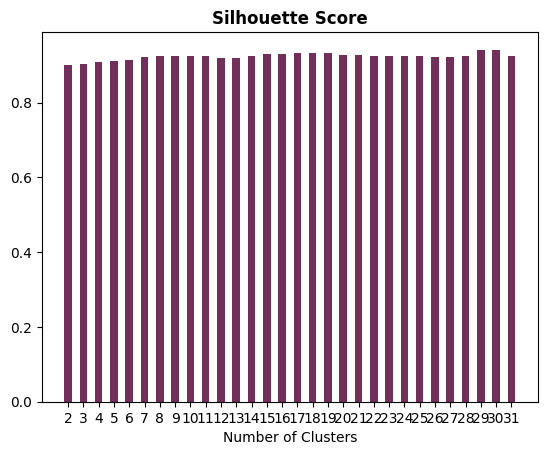

optimum_num_clusters: 29


In [18]:
# candidate values for our number of cluster
parameters = list(range(2, 32))
parameter_grid = ParameterGrid({'n_clusters': parameters})

# sample for silhouette search
rng = np.random.default_rng(42)
n = len(sdf_scaled)
sample_n = min(5000, n)
idx = rng.choice(n, size=sample_n, replace=False)
X_search = sdf_scaled.iloc[idx]

best_score = -1
best_grid = None
silhouette_scores = []

for p in parameter_grid:
    km = KMeans(
        n_clusters=p['n_clusters'],
        n_init=3,
        max_iter=100,
        algorithm="elkan",
        random_state=42
    )
    labels = km.fit_predict(X_search)
    ss = metrics.silhouette_score(
        X_search,
        labels,
        sample_size=min(2000, len(X_search)),
        random_state=42
    )
    silhouette_scores.append(ss)

    print('Parameter:', p, 'Score', ss)
    if ss > best_score:
        best_score = ss
        best_grid = p

# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

optimum_num_clusters = best_grid['n_clusters']
print("optimum_num_clusters:", best_grid['n_clusters'])


In [19]:
# fitting KMeans
print('Fitting..')
kmeans_n = KMeans(
    n_clusters=optimum_num_clusters,
    n_init=20,
    max_iter=300,
    algorithm="elkan",
    random_state=42
)
kmeans_n.fit(sdf_scaled)
centroids = kmeans_n.cluster_centers_
centroids_pca = pca_2.transform(centroids)
print("Optimum number of clusters= " + str(optimum_num_clusters))


Fitting..
Optimum number of clusters= 29


D:\testing\dune\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [20]:
# quick test to measure stability and choose an init number
inertias = []
x_for_kmeans = pca_2_result   # shape (n_samples, 2)

for i in range(5):
    km = KMeans(
        n_clusters=optimum_num_clusters,
        n_init=1,
        random_state=i,
        algorithm="elkan"
    )
    km.fit(x_for_kmeans)
    inertias.append(km.inertia_)

print("Stddev:", np.std(inertias))
print("Mean:", np.mean(inertias))
print("Ratio:", np.std(inertias)/np.mean(inertias))


Stddev: 161.50766804732342
Mean: 11780.624203421625
Ratio: 0.013709601907207455


In [ ]:
# another test to measure stability and choose an init number
inertias = []
for i in range(5):
    km = KMeans(
        n_clusters=optimum_num_clusters,
        n_init=10,
        random_state=i,
        algorithm="elkan"
    )
    km.fit(x_for_kmeans)
    inertias.append(km.inertia_)

print("Stddev:", np.std(inertias))
print("Mean:", np.mean(inertias))
print("Ratio:", np.std(inertias)/np.mean(inertias))
